# Deep Earth PREM: Travel time variations with different PREM CMB radii

Adam and Don also used the travel times of seismic body waves in defining PREM.  Here we set up a way to calculate travel times from an edited version of PREM.

As always, let's import a few things we need:

In [1]:
using SeisModels
import Plots
using Plots: plot, plot!, scatter, scatter!

┌ Info: Precompiling SeisModels [47bbc3d6-959e-5592-a00a-d17660d07a0f]
└ @ Base loading.jl:1273
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273


[SeisModels.jl](https://anowacki.github.io/SeisModels.jl/stable) defines planetary models, whilst [Plots.jl](http://docs.juliaplots.org/latest/) does the plotting.

In [2]:
using PyCall: pyimport
using TauPy

┌ Info: Precompiling TauPy [fa53487c-c63f-11e8-170c-e7abdb8d2806]
└ @ Base loading.jl:1273


The Julia module [TauPy.jl](https://github.com/anowacki/TauPy.jl) provides a wrapper around the Obspy `taup` module which works well for predefined models.   However, TauPy doesn't yet have a nice easy way to create `TauPyModel`s, so we need to use the [PyCall.jl](https://github.com/JuliaPy/PyCall.jl) package to help write a function to create an Obpsy `TauPyModel` from a `SeisModel`.  Let's go ahead and define this function:

In [3]:
const Taup = pyimport("obspy.taup")

"""
    taup_create(model) -> model

Create an Obspy `TauPyModel` from the seismic model `model`.
"""
function taup_create(m::LinearLayeredModel)
    mktempdir() do dir
        model_file = joinpath(dir, "model_file.tvel")
        write_tvel(model_file, m)
        Taup.taup_create.build_taup_model(model_file, output_folder=dir, verbose=true)
        Taup.tau.TauPyModel(joinpath(dir, "model_file"))
    end
end

taup_create

Note that `obspy.taup.taup_create.build_taup_model` needs something defined as a set of piecewise linear layers, as implemented by `SeisModels.LinearLayeredModel`, so we have to give it one of those.  Our PREM model will probably be defined by polynomials (and be a `SeisModels.PREMPolyModel`), but we can convert it to the right type just with the `LinearLayeredModel()` function.  Let's make a convenience method for `PREMPolyModel`s:

In [4]:
taup_create(m::PREMPolyModel) = taup_create(LinearLayeredModel(m))

taup_create (generic function with 2 methods)

(Congratulations—you just implemented multiple methods for a single function, and are now a practitioner of [multiple dispatch](https://en.wikipedia.org/wiki/Multiple_dispatch).)

First things first—we need to create a version of PREM which does not have an ocean layer on top, as `obpy.taup` can't cope with that.  We do what other people have done which is just replace the top layer (the ocean) with a copy of the layer below, in this case by just copying the polynomial coefficients from the penultimate layer to the final layer.

In [5]:
prem_no_ocean = deepcopy(PREM)
# Replace top (water) layer with the layer below, ignoring anisotropy and attenuation
# since we can't use these for travel time calculations with Obspy (though of course
# Dziewoński and Anderson managed it, with some help from John Woodhouse).
for f in (:vp, :vs, :density)
    getfield(prem_no_ocean, f)[:,end] .= getfield(prem_no_ocean, f)[:,end-1]
end

Now we can make some models based off this but with the radius of the second layer (outer core) perturbed from the original (and best?) PREM.

TauPy.jl currently requires you to put new models in its global `TauPy.MODEL` dictionary, so we given them a 'unique' name (or at least one we can refer to later).

In [6]:
# Make a set of models with the CMB elevated by ±10 km
models = Dict()
for δCMB in -10:10:10
    name = "prem_$(δCMB)"
    models[name] = deepcopy(prem_no_ocean)
    models[name].r[2] += δCMB
    TauPy.MODEL[name] = taup_create(models[name])
end

Armed with this set of models whose keys are their names, we can calculate some travel times!

In [7]:
for (phase, Δ) in zip(("ScS", "PKiKP"), (0, 120)), (name, model) in models
    arr = first(TauPy.travel_time(0, Δ, phase, model=name))
    @show phase, name, arr.time
end

(phase, name, arr.time) = ("ScS", "prem_-10", 938.5751408366539)
(phase, name, arr.time) = ("ScS", "prem_0", 935.822062952723)
(phase, name, arr.time) = ("ScS", "prem_10", 933.069025228345)
(phase, name, arr.time) = ("PKiKP", "prem_-10", 1129.071408279356)
(phase, name, arr.time) = ("PKiKP", "prem_0", 1130.1559178833866)
(phase, name, arr.time) = ("PKiKP", "prem_10", 1131.2452374429001)


Now we know how to do this, let's compute the travel time deviation between our models and PREM for a couple of different phases across several distances, ($\Delta$s).

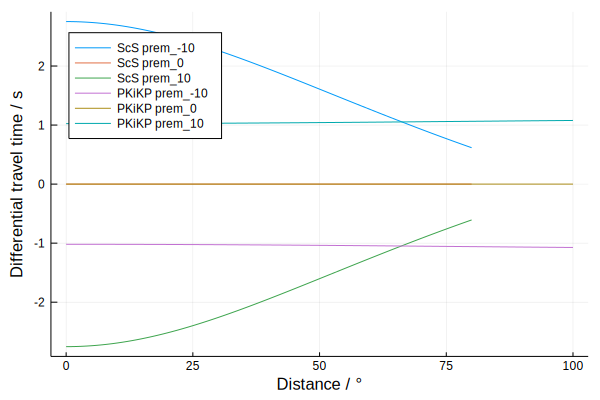

In [8]:
tt = Dict()
p = plot(legend=:topleft, xlabel="Distance / °", ylabel="Differential travel time / s")
for (phase, Δs) in zip(("ScS", "PKiKP"), (0:80, 0:100))
    tt["prem_0"] = (x->x.time).(first.(TauPy.travel_time.(0, Δs, phase, model="prem_0")))
    for name in keys(models)
        tt[name] = (x->x.time).(first.(TauPy.travel_time.(0, Δs, phase, model=name)))
        plot!(p, Δs, tt[name] .- tt["prem_0"], label="$phase $name")
    end
end
p

So shifting the CMB up (down) 10 km introduces an advance (delay) of ScS of up to 2.5 s, and a delay (advance) of PKiKP of a constant 1 s.

## PREM data

Let's have a look at some of the summary travel times used in PREM, in this case from Table VIe, showing PKPab arrival times corrected for event depths at 550 km:

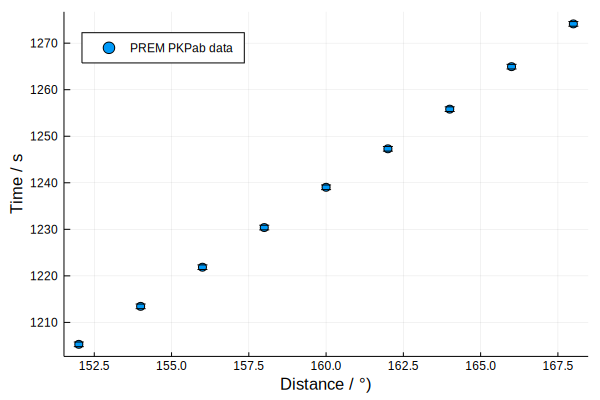

In [9]:
Δpkp, tpkp, ϵpkp = begin
    data = [152.00 1209.51 1205.29 0.50
            154.00 1217.67 1213.45 0.50
            156.00 1226.08 1221.86 0.50
            158.00 1234.60 1230.38 0.50
            160.00 1243.25 1239.03 0.50
            162.00 1251.52 1247.30 0.50
            164.00 1260.04 1255.82 0.50
            166.00 1269.17 1264.95 0.50
            168.00 1278.36 1274.14 0.50]
    data[:,1], data[:,3], data[:,4]
end

evt_depth = 0
p = scatter(Δpkp, tpkp, yerrorbar=ϵpkp, label="PREM PKPab data",
    legend=:topleft, xlabel="Distance / °)", ylabel="Time / s")

Now let's overlay our values for the models we have.

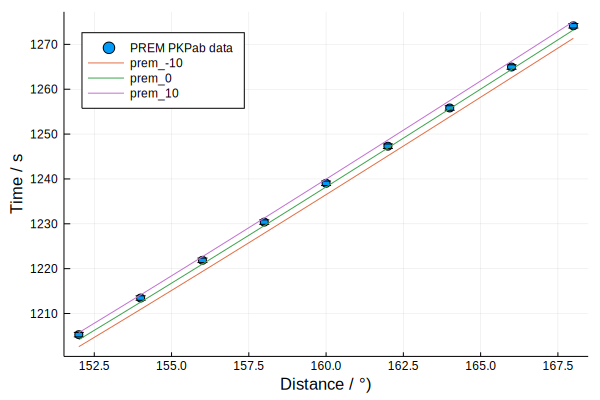

In [10]:
Δs = minimum(Δpkp):1:maximum(Δpkp)
for (name, model) in models
    # We want the last arriving PKP arrival as this is PKPab
    arrivals = last.(travel_time.(evt_depth, Δs, "PKP", model=name))
    pred_times = getfield.(arrivals, :time)
    plot!(p, Δs, pred_times, label=name, markeralpha=0.5)
end
p

It's pretty clear that if the errors are to be believed, without changing the mantle velocity you can't change the CMB radius by more than a few km without starting to lose the fit to the PKPab summary travel time data.

Just for comparison, how does AK135 compare?

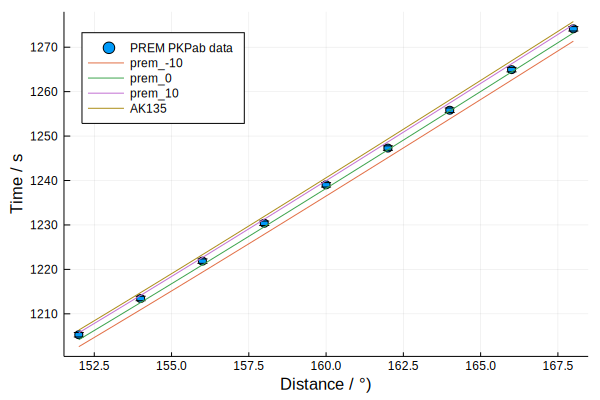

In [11]:
plot!(p, Δs, (x->x.time).(last.(travel_time.(evt_depth, Δs, "PKP", model="ak135"))),
    label="AK135")

So… AK135 has later PKPab than all ‘PREM’s without an ocean, even ones with a CMB that's 10 km higher.